# Generate figures from DESEq2 analysis

## Load data and generate DE results

In [1]:
library(tidyverse)
library(DESeq2)
library(dendextend)
library(RColorBrewer)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, uni

In [2]:
imgdir <- "Data/"

imgfile <- file.path(imgdir, "HIVdemo2021-DDS.RDS")

imgfile

tools::md5sum(imgfile)

ddsadd <- readRDS(imgfile)

[1] "Data//HIVdemo2021-DDS.RDS"

Data//HIVdemo2021-DDS.RDS 
"4ee9180e123d9745a0fa0e371df8cf4a"

In [3]:

### Estimate Size Factors
ddsadd <- estimateSizeFactors(ddsadd)
### Estimate Dispersion parameters (for each gene)
ddsadd <- estimateDispersions(ddsadd)
### Fit NB MLE model
ddsadd <- DESeq(ddsadd)

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 1 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



## Dot Plots

In [4]:
### Merge gene expression with meta data
myDEplotData <- function(mydds, geneid, mergelab) {
    counts(mydds, normalize = TRUE) %>%
        as_tibble(rownames="gene") %>%
        filter(gene == geneid) %>%
        gather(Label, geneexp, -gene) %>%
        select(-gene) -> genedat

    colData(mydds) %>%
        as.data.frame %>%
        as_tibble %>%
        full_join(genedat, by = mergelab) -> genedat
    
    return(genedat)
}

### Plot using a single factor
myDEplot0 <- function(mydds, geneid, grpvar, mergelab) {
    mydat <- myDEplotData(mydds, geneid, mergelab)
    ggplot(mydat, aes_string(x=grpvar, y = "geneexp", col = grpvar))+ geom_point()
}


### Allow for coloring with respect to another factor
myDEplot <- function(mydds, geneid, grpvar, colvar, mergelab) {
    mydat <- myDEplotData(mydds, geneid, mergelab)
    ggplot(mydat, aes_string(x=grpvar, y = "geneexp", col = colvar))+ geom_point()
}


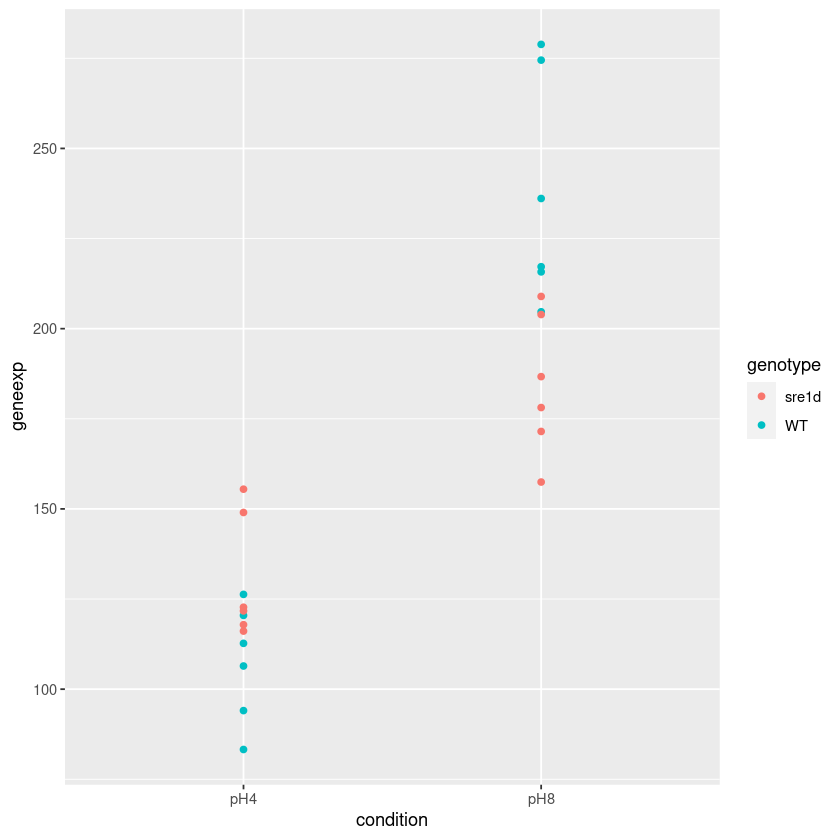

In [5]:
### Stratify by condition color by genotype
myDEplot(ddsadd, "CNAG_00003", "condition", "genotype", "Label")

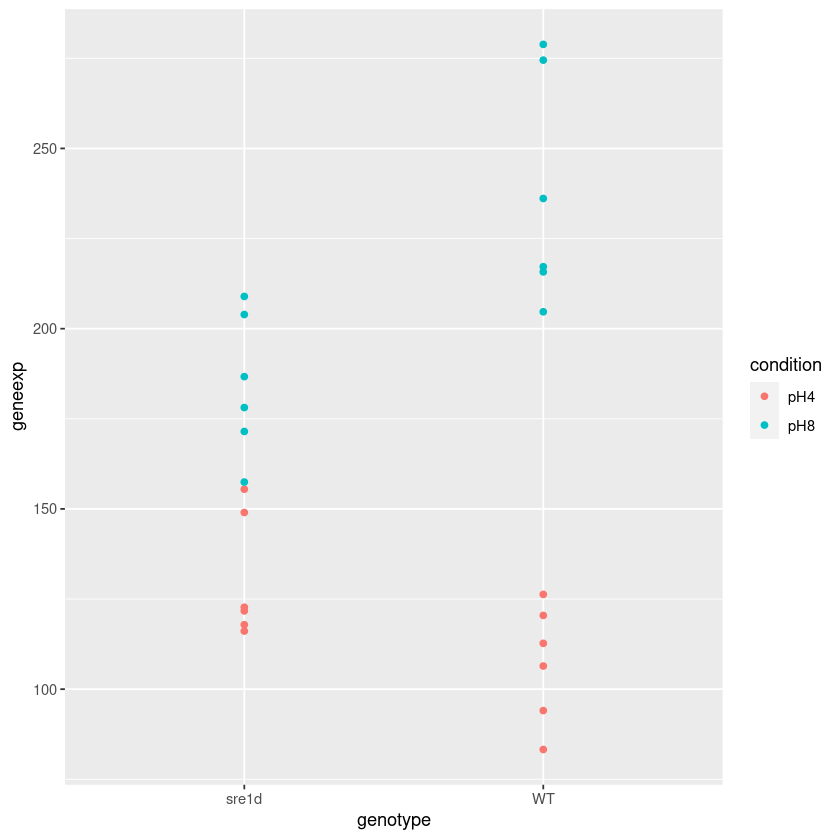

In [6]:
### Stratify by genotype color by conditon
myDEplot(ddsadd, "CNAG_00003", "genotype", "condition", "Label")

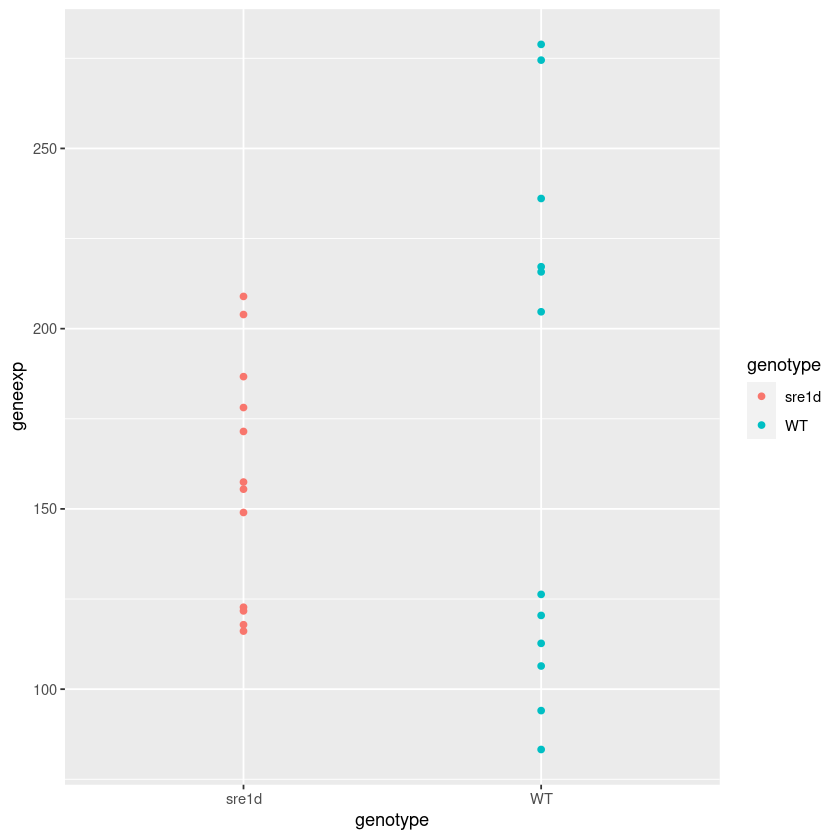

In [7]:
### Stratify by genotype
myDEplot0(ddsadd, "CNAG_00003", "genotype", "Label")

## Volcano plots

Warning message:
“Removed 191 rows containing missing values (geom_point).”


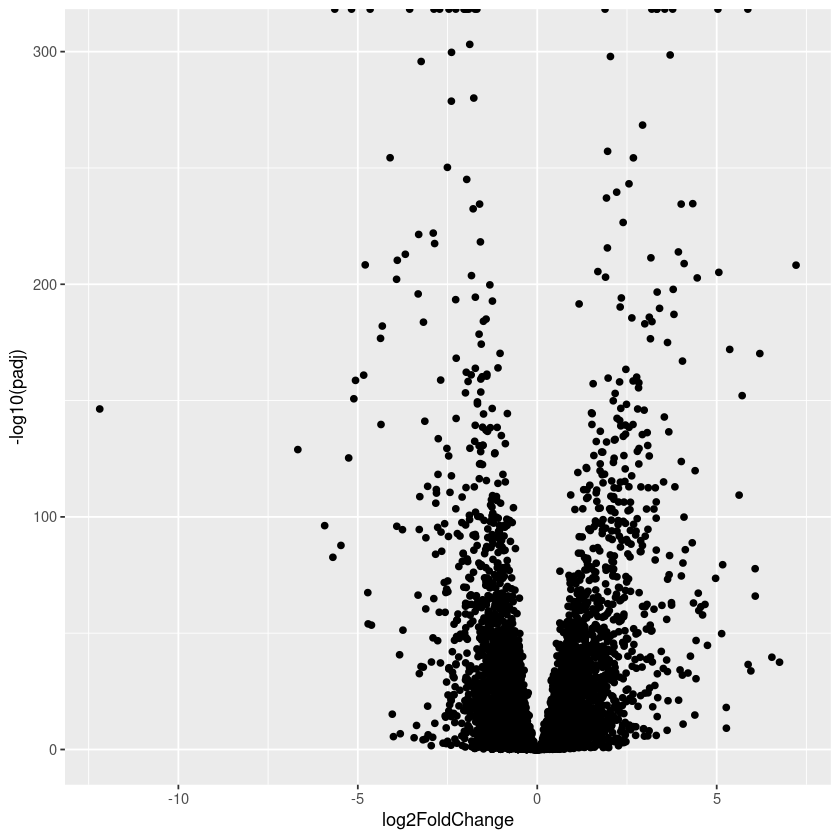

In [8]:
### Volcano plot for condition effect
ggplot(results(ddsadd, contrast = c("condition", "pH4", "pH8"), tidy = TRUE), 
       aes(x = log2FoldChange, y = -log10(padj))) + geom_point()

## 

## Get "expression" data from counts

In [9]:
### Normalized counts
normexp <- assay(ddsadd, normalize=TRUE)
class(normexp)

[1] "matrix" "array"

In [10]:
### rlog transform
rlexp <- rlog(ddsadd, blind = TRUE)
class(rlexp)

[1] "DESeqTransform"
attr(,"package")
[1] "DESeq2"

In [11]:
vstexp <- vst(ddsadd)
class(vstexp)

[1] "DESeqTransform"
attr(,"package")
[1] "DESeq2"

In [12]:
### FPM
fpmexp <- fpm(ddsadd)
class(normexp)

[1] "matrix" "array"

## Principal Components Analysis

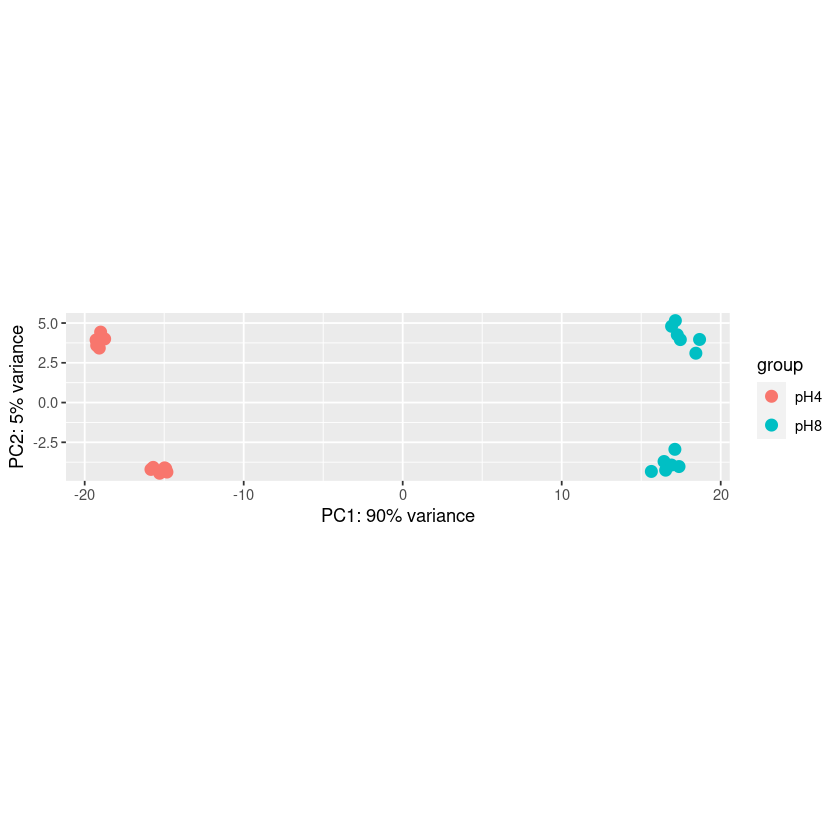

In [13]:
###  Color by condition
plotPCA(rlexp, intgroup = c("condition"))

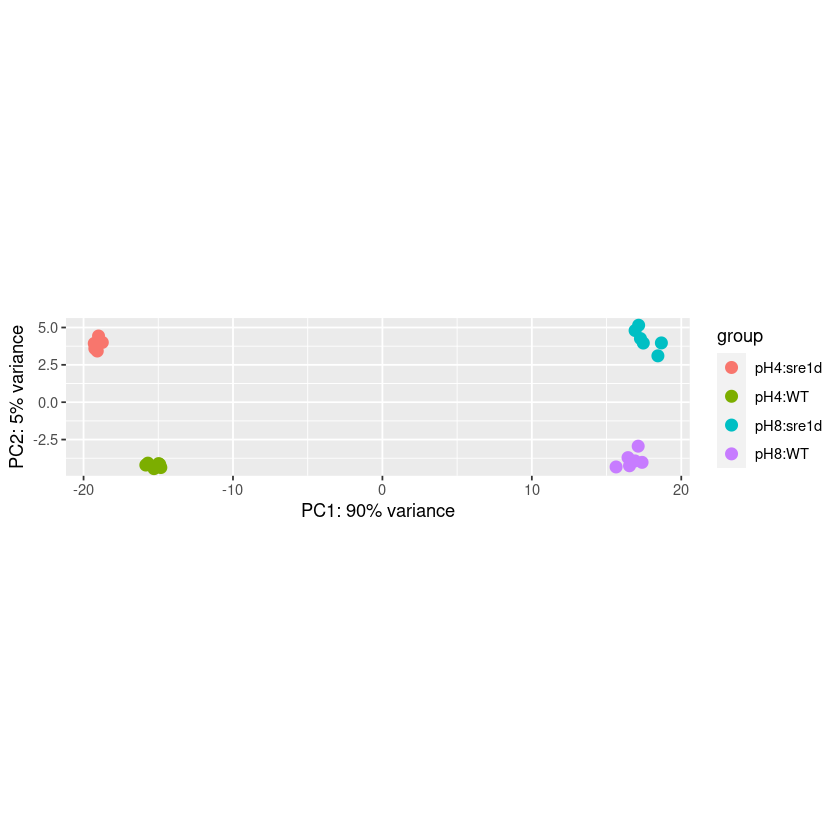

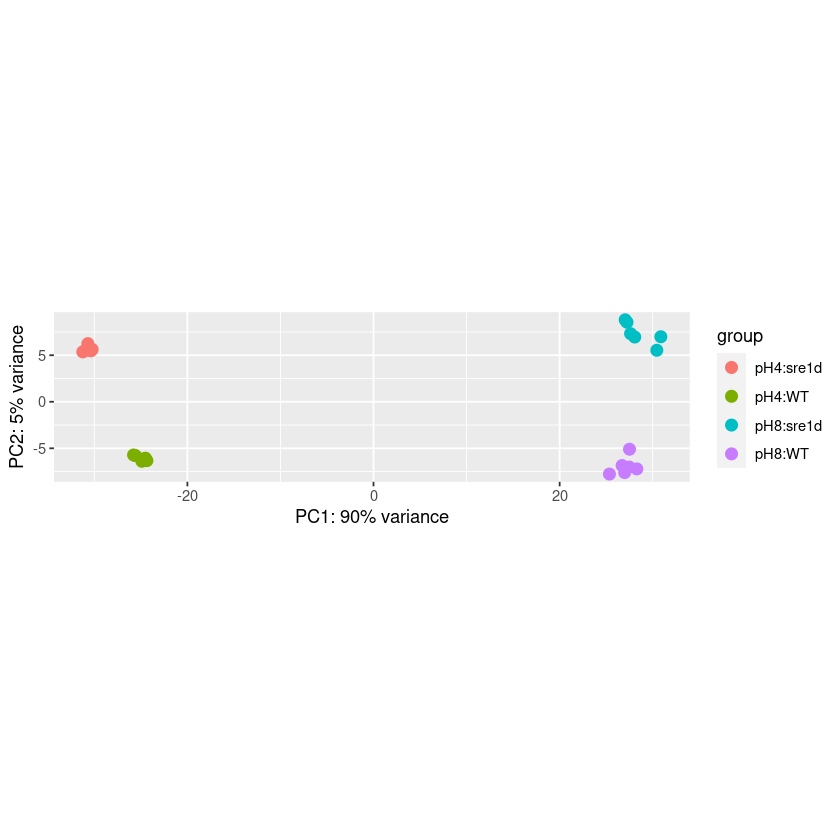

In [14]:
### Color by condition and genotype using rlog and then vst transformed counts
plotPCA(rlexp, intgroup = c("condition", "genotype"))
plotPCA(vstexp, intgroup = c("condition", "genotype"))

## Clustering

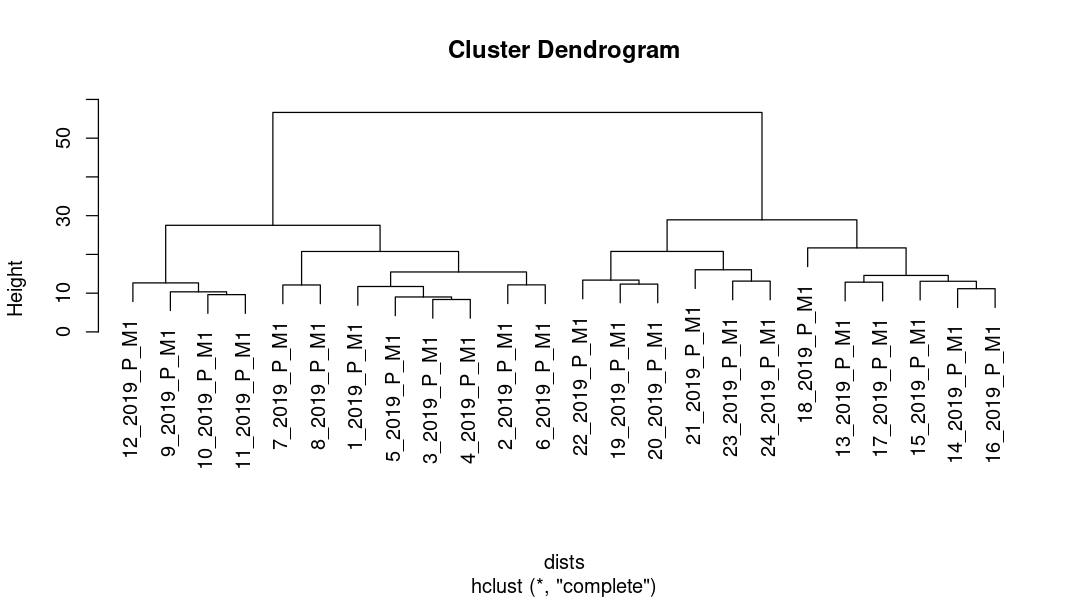

In [15]:
### Simple dendogram with no annotation
options(repr.plot.width = 9, repr.plot.height = 5)
dists <- dist(t(assay(rlexp)))
plot(hclust(dists, metho = "complete")) 

In [16]:
### Create dendogram object
assay(rlexp) %>%
    t() %>%
        dist %>%
            hclust(method = "complete") %>%
                as.dendrogram -> mydend

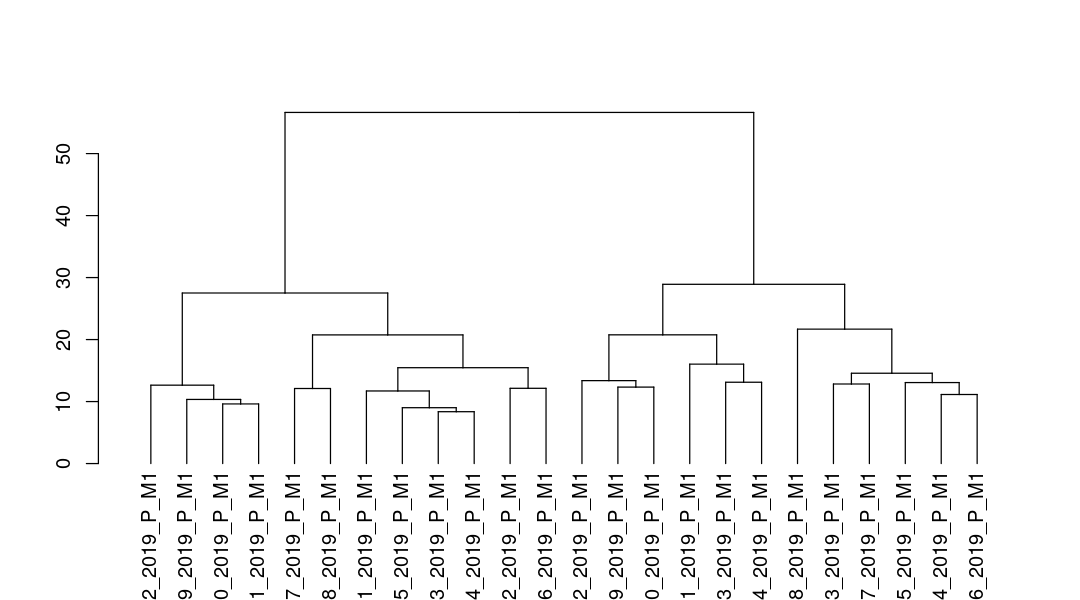

In [17]:
### Plot dendogram object
plot(mydend)

In [18]:
### Function to annotate dendogram object
dendplot <- function(mydend, columndata, labvar, colvar, pchvar) {
    cols <- factor(columndata[[colvar]][order.dendrogram(mydend)])
    collab <- brewer.pal(max(3,nlevels(cols)),"Set1")[cols]
    pchs <- factor(columndata[[pchvar]][order.dendrogram(mydend)])
    pchlab <- seq_len(nlevels(pchs))[pchs]
    lablab <- columndata[[labvar]][order.dendrogram(mydend)]
    
    mydend %>% 
        set("labels_cex",1) %>% 
        set("labels_col",collab) %>%
        set("leaves_pch",pchlab) %>%
        set("labels", lablab)
}

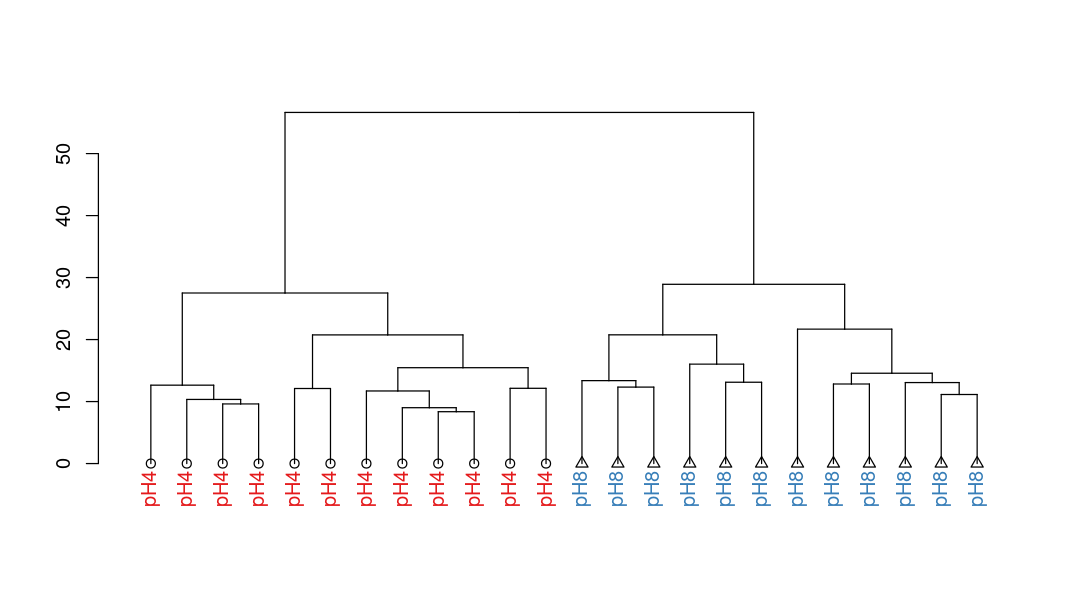

In [19]:
### Annotate by condition only
dendplot(mydend, ddsadd@colData, 
         "condition",    # variable that show in label
         "condition",    # variable that define color
         "condition") %>% # variable that define shape of points
    plot

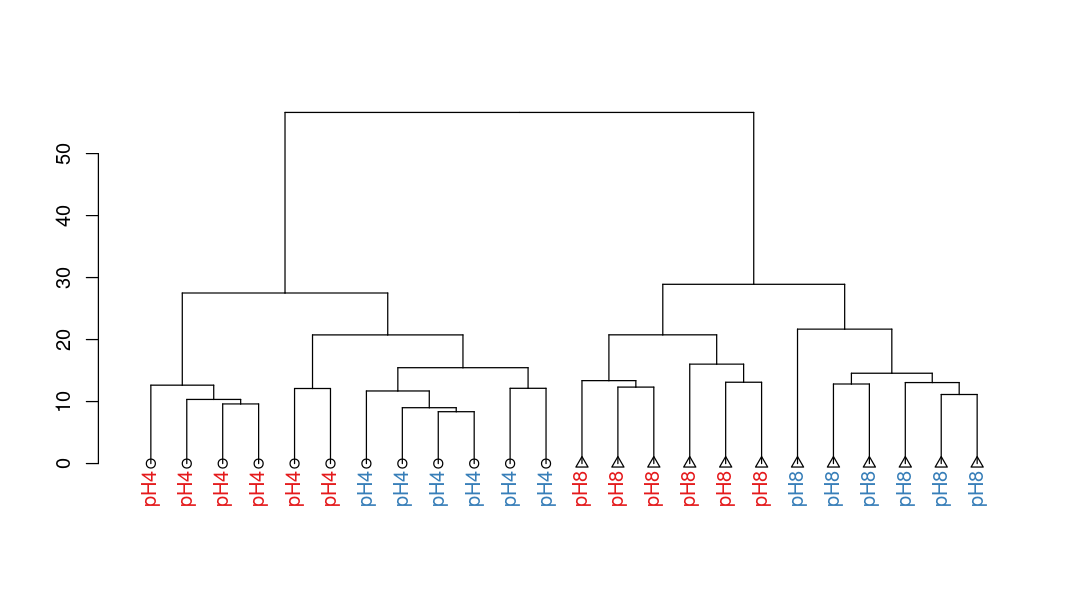

In [20]:
### label by condition color by genotype
dendplot(mydend, ddsadd@colData, 
         "condition",    # variabled that show in label
         "genotype",    # variable that define color
         "condition") %>% # variable that define shape of points
    plot

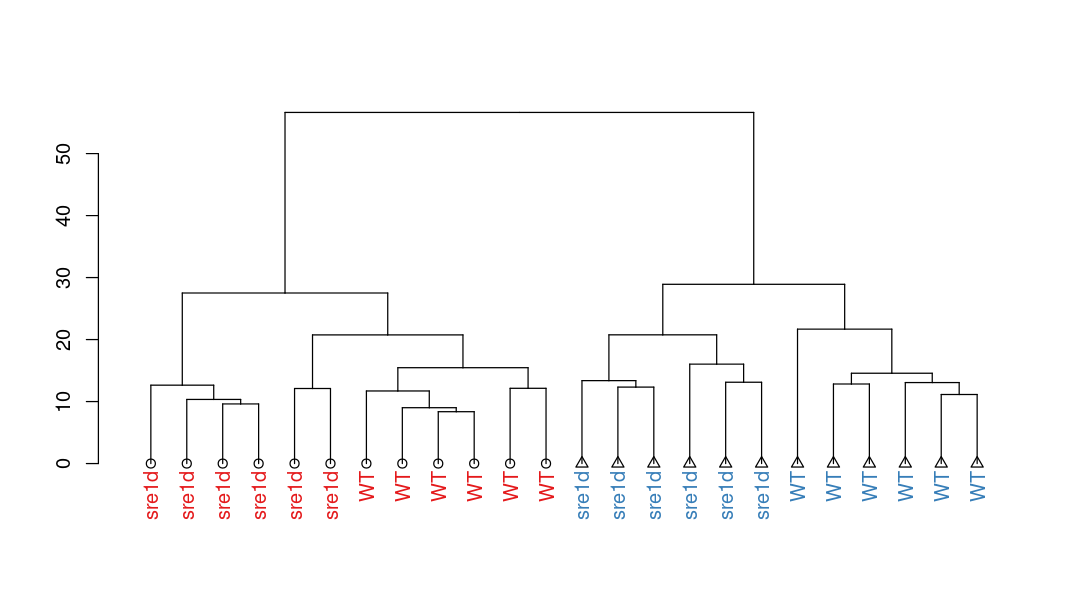

In [21]:
### label by genotype  color by condition
dendplot(mydend, ddsadd@colData, 
         "genotype",    # variable that show in label
         "condition",    # variable that define color
         "condition") %>% # variable that define shape of points
    plot

In [22]:
sessionInfo()

R version 4.0.4 (2021-02-15)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] RColorBrewer_1.1-2          dendextend_1.14.0          
 [3] DESeq2_1.30.1               SummarizedExperiment_1.20.0
 [5] Biobase_2.50.0              MatrixGenerics_1.2.1       
 [7] matrixStats_0.58.0          GenomicRanges_